# AWSにVM確保

----

開発用に Amazon&nbsp;EC2インスタンスを確保します。  


## *Operation Note*

*OpHub用*

## 事前条件

**事前にTerminalから、 `aws configure` を実施してください。**

`aws configure` の実施例:

```
$ aws configure
AWS Access Key ID [None]: (自身のアカウントのアクセスキー)
AWS Secret Access Key [None]: (自身のアカウントのシークレットアクセスキー)
Default region name [None]: ap-northeast-1 (使用したいリージョン)
Default output format [None]: json (jsonを指定)
```

アクセスキー管理方法は様々ありますが、AWS IAMのユーザー https://console.aws.amazon.com/iam/home?region=us-west-2#/users からNotebook用のユーザーを作成する方法があります。万が一アクセスキーが漏れた場合に備えて、権限を最小限に、いつでも無効化できるように設定する必要があります。

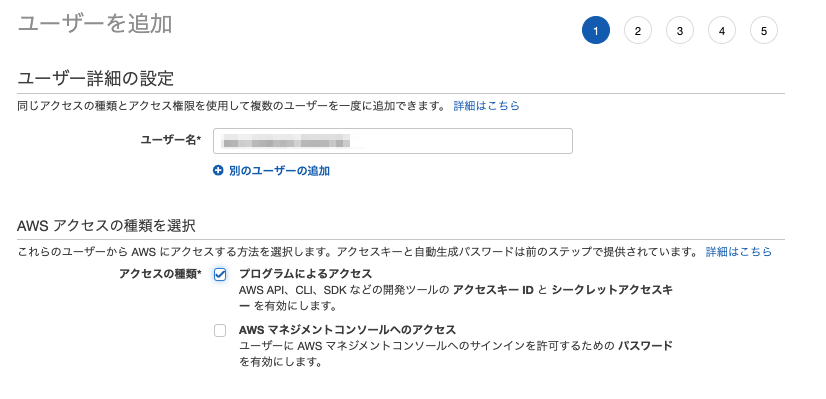

権限は `AmazonEC2FullAccess` を想定しています。

正しくアクセス情報が指定されているかどうかを、`describe-account-attributes`により確認します。**以下のコマンド実行がエラーとなる場合、`aws configure`が正しくなされていない可能性があります。**

In [2]:
!aws ec2 describe-account-attributes

{
    "AccountAttributes": [
        {
            "AttributeName": "supported-platforms",
            "AttributeValues": [
                {
                    "AttributeValue": "VPC"
                }
            ]
        },
        {
            "AttributeName": "vpc-max-security-groups-per-interface",
            "AttributeValues": [
                {
                    "AttributeValue": "5"
                }
            ]
        },
        {
            "AttributeName": "max-elastic-ips",
            "AttributeValues": [
                {
                    "AttributeValue": "5"
                }
            ]
        },
        {
            "AttributeName": "max-instances",
            "AttributeValues": [
                {
                    "AttributeValue": "25"
                }
            ]
        },
        {
            "AttributeName": "vpc-max-elastic-ips",
            "AttributeValues": [
                {
                    "AttributeValue": "20"
            

## 設定
インスタンスの生成に必要な情報を設定します。

マシンイメージを設定します。使用するリージョンに合わせてイメージIDは異なります。

> OperationHubを構築する https://github.com/NII-cloud-operation/OperationHub ことを想定し、CentOS 7を選択しています。

In [3]:
# CentOS 7
# ap-northeast-1を使用する場合
#image_id = 
# us-west-2 (オレゴン) を使用する場合
image_id = 'ami-0bc06212a56393ee1'

インスタンスタイプとインスタンス数を設定します。  
[Amazon EC2 インスタンス](https://aws.amazon.com/jp/ec2/instance-types/)のページから適切なタイプを選択してください。

例えば64GBのメモリを利用するのであれば **m4.4xlarge** が選択候補となります。  
利用したいサイズに応じてタイプを選んで下さい。

In [4]:
instance_type = 't3a.small'
instance_count = 1

データ蓄積ディスクとなる[EBS](http://docs.aws.amazon.com/ja_jp/AWSEC2/latest/UserGuide/AmazonEBS.html)の[ブロックデバイスマッピング](http://docs.aws.amazon.com/ja_jp/AWSEC2/latest/UserGuide/block-device-mapping-concepts.html)設定を行います。  
`VolumeSize`、`VolumeType`を設定します。  
`DeleteOnTermination`にtrueを設定すると、インスタンス破棄時にEBSが削除されます。  


In [5]:
block_device_mappings = {
    "DeviceName": "/dev/sda1",
    "Ebs": {
      "VolumeSize": 64,
      "VolumeType": "gp2",
      "DeleteOnTermination": "true",
    }
}

### Keypairの準備

使用するキーペア名を設定します。

In [6]:
resource_prefix = 'cloud-ophub'
resource_prefix

'cloud-ophub'

In [7]:
vmname = 'compute'
vmname

'compute'

以下のセルは、誤ってRun Allでまとめ実行した際に先に進まないように設定しています。
これまでのセル実行が問題なければ、以下のコードセルを選択してFreezeボタンを押してFreezeして先に進めてください。

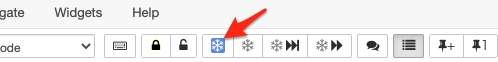

In [8]:
# ここまでのパラメータを確認したら本セルはFreezeして先に進める。
assert False

AssertionError: 

In [9]:
hostname = !hostname
keypair_name = '{}-{}'.format(resource_prefix, hostname[0])
keypair_name

'cloud-ophub-123c0aac1e0b'

本Notebookはインスタンスとの接続のために、 `~/.ssh/ansible_id_rsa` と言う名前の秘密鍵ファイルを生成します。
Notebook環境の `/home/jovyan` をホストディレクトリにマウントするなどして永続化していないと、この秘密鍵もコンテナの削除とともに消えますのでご注意ください。

> デモ用途なのでPassphraseなしで作っています。実際にはPassphraseをつけて、ssh-agentで鍵の取り回しをしています。

In [10]:
import os
ssh_keypath = os.path.expanduser('~/.ssh')
if not os.path.exists(os.path.join(ssh_keypath, 'ansible_id_rsa')):
    !ssh-keygen -t rsa -b 2048 -C ansible -f {ssh_keypath}/ansible_id_rsa -P ''
!cat {ssh_keypath}/ansible_id_rsa.pub

Generating public/private rsa key pair.
Created directory '/home/jovyan/.ssh'.
Your identification has been saved in /home/jovyan/.ssh/ansible_id_rsa
Your public key has been saved in /home/jovyan/.ssh/ansible_id_rsa.pub
The key fingerprint is:
SHA256:wzkH6ucomvSVgGDlKsyswp00CXqvyB2Jn7bjHOCmiBQ ansible
The key's randomart image is:
+---[RSA 2048]----+
|   .             |
|  o              |
|.o .    .        |
|*.o..  o o       |
|oEo+. . S .      |
|=.*.+o . +       |
|o*.*. + .        |
|Oo+*=. +         |
|=.*O+.. .        |
+----[SHA256]-----+
ssh-rsa AAAAB3NzaC1yc2EAAAADAQABAAABAQDHrNkbLoc/Lz43/pq3Uyl06lU+029GIT0WKzQEpu+z2wVI/CvdHrlKRVshxKS/G4xudXE5itsiRHxhMDwJY+uW5YpZ67A8aWUObGZK7ZIDzmliR8IEWBVppKZR1rTePAQKE+8Y5IAGE92GOn/lUma/xLQ1d/5FjkAXRH41tOKs9KRDxqb0ujfysGouwzNq5Tr6n5mcDKFh06JL5uMP3rCoPW7NMXvcvSx7iFhq4vNLteE90kTec7PoNZscrs0DSedvLhe12f+5Q1Sh2BAxAfQxpXCH2O8r16QFlR0XIG+e5AlDOt5X/Y3FQxH9qEHK90Z/Js4gicsHVBXJDjqNAJJx ansible


In [ ]:
import json
result = !aws ec2 describe-key-pairs
keypairs = json.loads('\n'.join(result))['KeyPairs']
print('{} keys'.format(len(keypairs)))

本Notebookは設定された resource_prefix 変数と hostname を使ってキーペア名を決定します。同一名称のキーペア名があれば特に何もしません。

In [12]:
if keypair_name not in [k['KeyName'] for k in keypairs]:
    !aws ec2 import-key-pair --key-name {keypair_name} --public-key-material file://{ssh_keypath}/ansible_id_rsa.pub

{
    "KeyFingerprint": "63:42:16:06:53:23:07:c2:0d:a2:a1:38:16:16:72:83",
    "KeyName": "cloud-ophub-123c0aac1e0b",
    "KeyPairId": "key-096bf367c2e527af2"
}


### VPCの準備

Elasticsearch構築Notebookは、VPCに仮想マシンを確保します。

すでに作成してあるVPC, Subnetに仮想マシンを作成したい場合は、以下に入力してください。

In [13]:
# vpc_id = 'vpc-xxxxxxxx'
# subnet_id = 'subnet-xxxxxxxx'

`vpc_id` が指定されたなかった場合は、本Notebookは `{resource_prefix}` という名前のVPCを構築し、Internet Gatewayをアタッチします。
以下のセルを実行してください。(すでに同一名称のVPCがあればそれを利用します)

> VPC, Subnetが不要になったら、AWSコンソールからVPCに関連するリソースを削除してください。

In [14]:
if 'vpc_id' not in locals():
    vpc_cidr_block = '10.30.0.0/16'
    # VPCの検索
    result = !aws ec2 describe-vpcs
    vpcs = json.loads(''.join(result))['Vpcs']
    tagged_vpcs = [dict([(t['Key'], t['Value']) for t in vpc['Tags']] + [('VpcId', vpc['VpcId'])])
                   for vpc in vpcs if 'Tags' in vpc]
    target_vpcs = [v for v in tagged_vpcs if 'Name' in v and v['Name'] == resource_prefix]
    if len(target_vpcs) == 0:
        # VPCの作成
        result = !aws ec2 create-vpc --cidr-block {vpc_cidr_block}
        print('create-vpc', ''.join(result))
        new_vpc_id = json.loads(''.join(result))['Vpc']['VpcId']
        print('VPC created: {}'.format(new_vpc_id))
        !aws ec2 modify-vpc-attribute --vpc-id {new_vpc_id} --enable-dns-hostnames "{{\"Value\":true}}"
        !aws ec2 create-tags --resources {new_vpc_id} --tags Key=Name,Value={resource_prefix}

        # Subnetの作成
        result = !aws ec2 create-subnet --vpc-id {new_vpc_id} --cidr-block {vpc_cidr_block}
        new_subnet_id = json.loads(''.join(result))['Subnet']['SubnetId']
        print('Subnet created: {}'.format(new_subnet_id))
        !aws ec2 create-tags --resources {new_subnet_id} --tags Key=Name,Value={resource_prefix}

        # Internet Gateway
        result = !aws ec2 create-internet-gateway
        new_internetgateway_id = json.loads(''.join(result))['InternetGateway']['InternetGatewayId']
        !aws ec2 attach-internet-gateway --internet-gateway-id {new_internetgateway_id} --vpc-id {new_vpc_id}
        !aws ec2 create-tags --resources {new_internetgateway_id} --tags Key=Name,Value={resource_prefix}
        # route
        result = !aws ec2 describe-route-tables
        routes = json.loads(''.join(result))['RouteTables']
        target_routes = [r['RouteTableId']
                         for r in routes if 'VpcId' in r and r['VpcId'] == new_vpc_id]
        assert len(target_routes) > 0
        !aws ec2 create-route --route-table-id {target_routes[0]} --destination-cidr-block '0.0.0.0/0' --gateway-id {new_internetgateway_id}

        vpc_id = new_vpc_id
        subnet_id = new_subnet_id
    else:
        existing_vpc_id = target_vpcs[0]['VpcId']
        print('VPC found: {}'.format(existing_vpc_id))

        # Subnetの検索
        result = !aws ec2 describe-subnets
        subnets = json.loads(''.join(result))['Subnets']
        tagged_subnets = [dict([(t['Key'], t['Value']) for t in subnet['Tags']] + \
                               [('SubnetId', subnet['SubnetId']), ('VpcId', subnet['VpcId'])])
                          for subnet in subnets if 'Tags' in subnet and 'VpcId' in subnet]
        target_subnets = [v for v in tagged_subnets if 'Name' in v and v['Name'] == resource_prefix]
        target_subnets = [v for v in target_subnets if v['VpcId'] == existing_vpc_id]
        assert len(target_subnets) > 0
        existing_subnet_id = target_subnets[0]['SubnetId']
        print('Subnet found: {}'.format(existing_subnet_id))

        vpc_id = existing_vpc_id
        subnet_id = existing_subnet_id
(vpc_id, subnet_id)

VPC found: vpc-0203ead2253bb832e
Subnet found: subnet-08e2f585c1b508a58


('vpc-0203ead2253bb832e', 'subnet-08e2f585c1b508a58')

### Security Groupの準備

Security GroupもVPC同様に準備します。

すでに作成してあるSecurity Groupを使用する場合は、以下にIDを設定してください。

In [15]:
#security_group_id = 'sg-xxxxxxxx'

VPC同様、IDが設定されていない場合は、Security Groupを生成します。許可範囲は最低限として、あとで必要に応じて開けていきます。

In [16]:
if 'security_group_id' not in locals():
    result = !aws ec2 describe-security-groups
    sgs = json.loads(''.join(result))['SecurityGroups']
    tagged_sgs = [dict([(t['Key'], t['Value']) for t in sg['Tags']] + \
                       [('GroupId', sg['GroupId']), ('VpcId', sg['VpcId'])])
                   for sg in sgs if 'Tags' in sg and 'VpcId' in sg]
    target_sgs = [sg for sg in tagged_sgs if 'Name' in sg and sg['Name'] == resource_prefix and sg['VpcId'] == vpc_id]
    if len(target_sgs) == 0:
        result = !aws ec2 create-security-group --group-name {resource_prefix} --description {resource_prefix} --vpc-id {vpc_id}
        new_sg_id = json.loads(''.join(result))['GroupId']
        print('Security Group created: {}'.format(new_sg_id))
        !aws ec2 create-tags --resources {new_sg_id} --tags Key=Name,Value={resource_prefix}
        security_group_id = new_sg_id
    else:
        existing_sg_id = target_sgs[0]['GroupId']
        print('Security Group found: {}'.format(existing_sg_id))
        security_group_id = existing_sg_id
security_group_id

Security Group found: sg-030b0e7135b1d4046


'sg-030b0e7135b1d4046'

## EC2インスタンスの起動・設定

サーバ構成に応じたEC2インスタンスを起動し、各種設定を実施します。


### インスタンスの起動

ここまでで設定した定義を用いてインスタンスを生成します。

以下では、AWSに対してインスタンス起動要求を発行しています。


In [ ]:
def get_block_device_mappings_repr(o):
    return ','.join(map(lambda kv: '{}={}'.format(kv[0],
                                                  '{' + get_block_device_mappings_repr(kv[1]) + '}' if kv[0] == 'Ebs' else kv[1]),
                        o.items()))

result = !aws ec2 run-instances --image-id {image_id} \
                                --count {instance_count} \
                                --instance-type {instance_type} \
                                --key-name {keypair_name} \
                                --block-device-mappings '{get_block_device_mappings_repr(block_device_mappings)}' \
                                --security-group-ids {security_group_id} \
                                --subnet-id {subnet_id}
try:
    instances = json.loads('\n'.join(result))['Instances']
except ValueError:
    raise ValueError('\n'.join(result))
instances


生成したインスタンスIDを確認します。

In [18]:
id_list = [i['InstanceId'] for i in instances]
id_list_text = ' '.join(id_list)
id_list

['i-015ff3d8fc422cd42']


インスタンスの状態が running になるまで待ちます。

In [19]:
from functools import reduce
import time

retries = 10
while retries > 0:
    # インスタンス情報を取得
    desc_instances_stdout = !aws ec2 describe-instances --instance-ids $id_list_text
    try:
        json.loads('\n'.join(desc_instances_stdout))
    except:
        print('\n'.join(desc_instances_stdout))
    
    # JSON化し、インスタンスのリストとして取り出す
    desc_instances = json.loads('\n'.join(desc_instances_stdout))
    target_instances = reduce(lambda x, y: x + y, map(lambda r: r['Instances'], desc_instances['Reservations']))
    # IDと状態を出力
    status_text = '\n'.join(map(lambda i : '{0} : {1}'.format(i['InstanceId'], i['State']['Name']), target_instances))
    print(status_text)
    # runningになっていないものがまだあれば、スリープして最初に戻る。全てrunningなら終了。
    not_running_num = len(list(filter(lambda i : i['State']['Name'] != 'running', target_instances)))
    if not_running_num == 0:
        break
    print('Not running : {0}'.format(not_running_num))
    time.sleep(5)
    print('------')
    retries -= 1

for i in target_instances:
    assert i['State']['Name'] == 'running'
host_list = [i['PrivateIpAddress'] for i in target_instances]
host_list

i-015ff3d8fc422cd42 : pending
Not running : 1
------
i-015ff3d8fc422cd42 : running


['10.30.160.19']

### タグの設定

タグのNameキーに名称を設定します。

In [20]:
!aws ec2 create-tags --resources {id_list_text} --tags Key=Name,Value={resource_prefix}-{vmname}

### Elastic IPの設定

インスタンスにElastic IPを設定します。

In [ ]:
for i in target_instances:
    result = !aws ec2 allocate-address
    new_eip = json.loads(''.join(result))
    !aws ec2 associate-address --allocation-id {new_eip['AllocationId']} --instance-id {i['InstanceId']}

host_list = []
desc_instances_stdout = !aws ec2 describe-instances --instance-ids $id_list_text
desc_instances = json.loads('\n'.join(desc_instances_stdout))
target_instances = list(reduce(lambda x, y: x + y, list(map(lambda r: r['Instances'], desc_instances['Reservations']))))
for i in target_instances:
    host_list.append((i['InstanceId'], i['PublicDnsName'], i['PublicIpAddress'], i['PrivateIpAddress']))
host_list

## Inventory作成用のインスタンスリストを作成
ホストのパブリックDNS一覧をリスト化します  

In [22]:
print('host_list = {}'.format(repr(dict([('host{}'.format(i + 1), h) for i, h in enumerate(host_list)]))))

host_list = {'host1': ('i-015ff3d8fc422cd42', 'ec2-52-42-214-180.us-west-2.compute.amazonaws.com', '52.42.214.180', '10.30.160.19')}


## Ansibleでの疎通確認

Ansibleよりpingが打てるかどうかを確認します。

In [23]:
import tempfile
work_dir = tempfile.mkdtemp()
work_dir

'/tmp/tmppvl6xn4b'

In [24]:
default_username = 'centos'
default_username

'centos'

In [25]:
import os

with open(os.path.join(work_dir, 'hosts'), 'w') as f:
    for iid, host, pubip, private_ip in host_list:
        f.write('{host} ansible_ssh_user={user} ansible_ssh_private_key_file={pkpath} ansible_python_interpreter=/usr/bin/python\n'.format(host=host,
                                                                                              user=default_username,
                                                                                              pkpath='~/.ssh/ansible_id_rsa'))

!cat {work_dir}/hosts

ec2-52-42-214-180.us-west-2.compute.amazonaws.com ansible_ssh_user=centos ansible_ssh_private_key_file=~/.ssh/ansible_id_rsa ansible_python_interpreter=/usr/bin/python


### Security Groupの変更

では、VMインスタンスが起動したようなので、Notebook環境から疎通確認をする。VMインスタンスのSecurity Groupは**デフォルトではどこからも接続を受け入れないようにしている**ので以下のURLから設定変更する。

AnsibleでのVM操作にはSSH(TCPポート22)を使用するので、このポートを許可するよう適切なアクセス元IPアドレスを指定する。

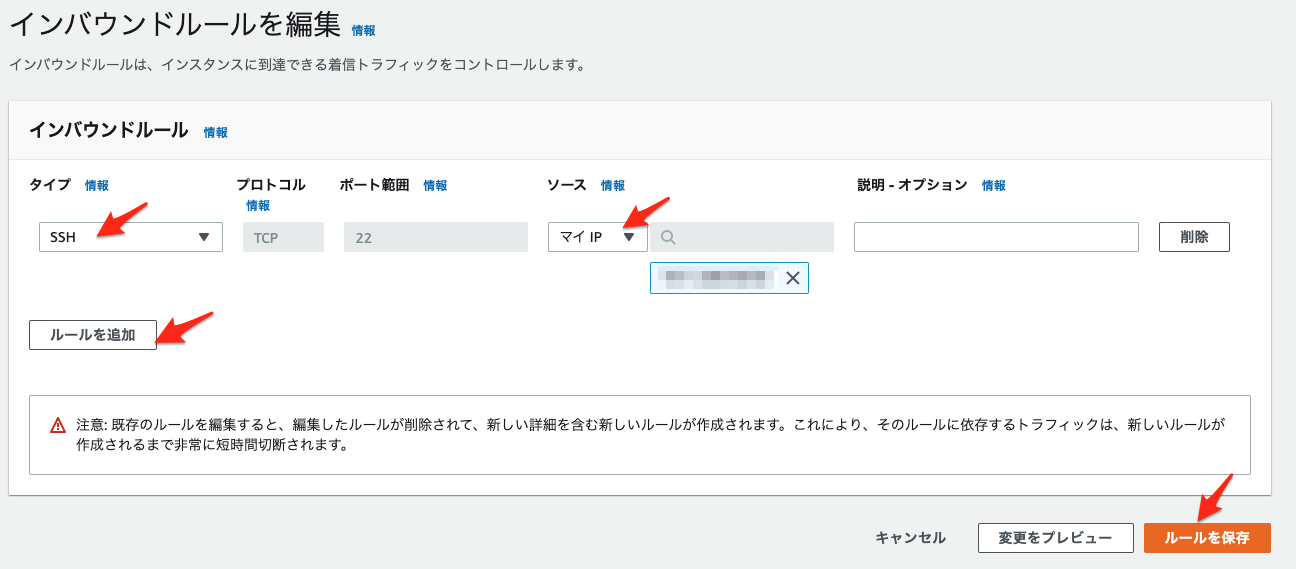

In [ ]:
regions = !aws configure get region
print('https://{region}.console.aws.amazon.com/ec2/v2/home?region={region}#SecurityGroup:groupId={security_group_id}'.format(region=regions[0], security_group_id=security_group_id))

In [27]:
# セキュリティグループの設定を行ったらFreezeして先に進める
assert False

AssertionError: 

In [28]:
%%writefile {work_dir}/init-password-abc
#!/usr/bin/expect

set host [lindex $argv 0]
set key [lindex $argv 1]
set username [lindex $argv 2]

spawn env LANG=C ssh -i $key "${username}\@${host}"

expect {
    -glob "(yes/no/*)?" {
        send "yes\n"
        exp_continue
    }
}

exit 0



Writing /tmp/tmppvl6xn4b/init-password-abc


In [32]:
import time

# VMのsshserverが落ち着くまで待つ...
time.sleep(60)

In [ ]:
for _, target_hostname, _, _ in host_list:
    !ssh-keygen -R {target_hostname} || exit 0
    !expect {work_dir}/init-password-abc {target_hostname} ~/.ssh/ansible_id_rsa {default_username}

In [ ]:
!ansible -m ping -i {work_dir}/hosts all

上記のセルがエラーとなる場合は、以下のように `-vvvv` オプションをつけてどんなメッセージが流れているかを確認してみましょう。

> !ansible -vvvv -m ping -i {work_dir}/hosts all
>
> Connection timed out の場合は、先のSecurity Groupがあっているかを確認すると良い...

OK。

# Inventoryへの追記

さてこれでVMが確保できました。Inventoryにhost情報を追記して、Ansibleからアクセスできるようにしましょう。


In [35]:
if not os.path.exists('./hosts'):
    !touch ./hosts
!cp ./hosts {work_dir}/hosts-backup

Inventoryに記述する例は以下のような感じ...

In [36]:
print('[{}]'.format(vmname))
!cat {work_dir}/hosts

[compute]
ec2-52-42-214-180.us-west-2.compute.amazonaws.com ansible_ssh_user=centos ansible_ssh_private_key_file=~/.ssh/ansible_id_rsa ansible_python_interpreter=/usr/bin/python


Inventoryを編集する。
1. [このNotebookがあるディレクトリ](/tree/05_AWS_VMへのOpHub環境構築例) と同じ階層に `hosts` というファイルがあるので、これをクリックしてエディタを開く
2. 上記セルの `[(VM名)]` と次の行をコピー＆ペーストする

In [37]:
# hostsファイルを編集したらFreezeして先に進める
assert False

AssertionError: 

`hosts`の変更差分を控えておく。

In [38]:
!diff -u {work_dir}/hosts-backup ./hosts || exit 0

--- /tmp/tmppvl6xn4b/hosts-backup	2020-07-02 02:15:14.924635210 +0000
+++ ./hosts	2020-07-02 02:15:29.360636517 +0000
@@ -0,0 +1,2 @@
+[compute]
+ec2-52-42-214-180.us-west-2.compute.amazonaws.com ansible_ssh_user=centos ansible_ssh_private_key_file=~/.ssh/ansible_id_rsa ansible_python_interpreter=/usr/bin/python
\ No newline at end of file


`hosts` ファイルのテストを実施する。

Ansibleに上記で設定したグループ名を与えてpingモジュールを実行する。

In [39]:
target_group = '-i ./hosts {}'.format(vmname)
target_group

'-i ./hosts compute'

In [40]:
!ansible -m ping {target_group}

ec2-52-42-214-180.us-west-2.compute.amazonaws.com | SUCCESS => {
    "changed": false,
    "ping": "pong"
}


In [41]:
# 上記セルの実行に失敗しないことを確認して、Freezeして先に進める。
assert False

AssertionError: 

# 後始末

一時ディレクトリの内容を削除する。

In [42]:
!rm -fr {work_dir}

これでVMの準備は完了です！